# Case 21.5 Taxi Cancellations

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> Case study included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.

In [1]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from dmba import classificationSummary, gainsChart

DATA = Path('.').resolve().parent / 'data'

# Load the data

In [2]:
taxi_df = pd.read_csv(DATA / 'Taxi-cancellation-case.csv')
taxi_df.head()

,row#,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,to_date,online_booking,mobile_site_booking,booking_created,from_lat,from_long,to_lat,to_long,Car_Cancellation
0,1,17712,12,NaN,2,1021.0,1323.0,NaN,NaN,1/1/13 22:33,NaN,0,0,1/1/13 8:01,13.028530,77.54625,12.869805,77.653211,0
1,2,17037,12,NaN,2,455.0,1330.0,NaN,NaN,1/1/13 12:43,NaN,0,0,1/1/13 9:59,12.999874,77.67812,12.953434,77.706510,0
2,3,761,12,NaN,2,814.0,393.0,NaN,NaN,1/2/13 0:28,1/3/13 0:00,1,0,1/1/13 12:14,12.908993,77.68890,13.199560,77.706880,0
3,4,868,12,NaN,2,297.0,212.0,NaN,NaN,1/1/13 13:12,NaN,0,0,1/1/13 12:42,12.997890,77.61488,12.994740,77.607970,0
4,5,21716,28,NaN,2,1237.0,330.0,NaN,NaN,1/1/13 16:33,NaN,0,0,1/1/13 15:07,12.926450,77.61206,12.858833,77.589127,0


# Step 1:
How can a predictive model based on these data be used by Yourcabs.com? 

Yourcabs.com could identify at risk calls and generate re-confirmations with drivers. 

# Step 2:
How can a profiling model (identifying predictors that distinguish canceled/uncanceled trips) be used by Yourcabs.com? 

An automated system to predict and flag potential cancellations could be used to generate re-confirmations with drivers, while an understanding of the role of predictor variables could be used in adjusting operations (e.g. if certain geographic areas are prone to cancellation, drivers could be interviewed to determine why).


# Step 3:
Explore, prepare, and transform the data to facilitate predictive modeling.  Here are some hints:  

- In exploratory modeling, it is useful to move fairly soon to at least an initial model without solving _all_ data preparation issues.  One example is the GPS information - other geographic information is available so you could defer the challenge of how to interpret/use the GPS information.
- How will you deal with missing data, such as cases where NaN is indicated? 
- Think about what useful information might be held within the date and time fields (the booking timestamp and the trip timestamp). The data file contains a worksheet with some hints on how to extract features from the date/time field.
- Think also about the categorical variables, and how to deal with them. Should we turn them all into dummies?  Use only some? 



Here, we set all missing data to 0. We will see later that this is not the best strategy for the GPS information, but we will handle this separately.

In [3]:
# Set all NaN to zero
taxi_df = taxi_df.fillna(0)

# convert a number of columns to categories
taxi_df.vehicle_model_id = taxi_df.vehicle_model_id.astype('category')
taxi_df.package_id = taxi_df.package_id.astype('category')
taxi_df.travel_type_id = taxi_df.travel_type_id.astype('category')

# convert date to day of week and time
taxi_df.from_date = pd.to_datetime(taxi_df.from_date, infer_datetime_format=True)
taxi_df.to_date = pd.to_datetime(taxi_df.to_date, infer_datetime_format=True)
taxi_df.booking_created = pd.to_datetime(taxi_df.booking_created, infer_datetime_format=True)
taxi_df['from_date_Hour'] = taxi_df.from_date.dt.hour
taxi_df['to_date_Hour'] = taxi_df.to_date.dt.hour
taxi_df['booking_created_Hour'] = taxi_df.booking_created.dt.hour
taxi_df['from_date_DOW'] = taxi_df.from_date.dt.dayofweek
taxi_df['to_date_DOW'] = taxi_df.to_date.dt.dayofweek
taxi_df['booking_created_DOW'] = taxi_df.booking_created.dt.dayofweek

taxi_df.head()

,row#,user_id,vehicle_model_id,package_id,travel_type_id,from_area_id,to_area_id,from_city_id,to_city_id,from_date,...,from_long,to_lat,to_long,Car_Cancellation,from_date_Hour,to_date_Hour,booking_created_Hour,from_date_DOW,to_date_DOW,booking_created_DOW
0,1,17712,12,0.0,2,1021.0,1323.0,0.0,0.0,2013-01-01 22:33:00,...,77.54625,12.869805,77.653211,0,22,0,8,1,3,1
1,2,17037,12,0.0,2,455.0,1330.0,0.0,0.0,2013-01-01 12:43:00,...,77.67812,12.953434,77.706510,0,12,0,9,1,3,1
2,3,761,12,0.0,2,814.0,393.0,0.0,0.0,2013-01-02 00:28:00,...,77.68890,13.199560,77.706880,0,0,0,12,2,3,1
3,4,868,12,0.0,2,297.0,212.0,0.0,0.0,2013-01-01 13:12:00,...,77.61488,12.994740,77.607970,0,13,0,12,1,3,1
4,5,21716,28,0.0,2,1237.0,330.0,0.0,0.0,2013-01-01 16:33:00,...,77.61206,12.858833,77.589127,0,16,0,15,1,3,1


In [4]:
import math

# compute trip length from GPS data
def distance(s_lat, s_lng, e_lat, e_lng):
    # approximate radius of earth in km
    R = 6373.0
    s_lat = s_lat * np.pi/180.0                      
    s_lng = np.deg2rad(s_lng)     
    e_lat = np.deg2rad(e_lat)                       
    e_lng = np.deg2rad(e_lng)  
    d = np.sin((e_lat - s_lat) / 2)**2 + np.cos(s_lat) * np.cos(e_lat) * np.sin((e_lng - s_lng) / 2)**2
    return 2 * R * np.arcsin(np.sqrt(d))

taxi_df['trip_length'] = distance(taxi_df.from_lat, taxi_df.from_long, taxi_df.to_lat, taxi_df.to_long)
taxi_df['trip_length'].head(10)

0      21.121893
1       6.012612
2      32.378385
3       0.826818
4       7.921406
5      26.321281
6       9.077398
7      19.955680
8    8672.376802
9       7.262777
Name: trip_length, dtype: float64

It is useful to look at the calculated trip_length critically. As you can see, most trip lengths are less than 100 km. However, there are a few cases, where the trip length is more than 8000 km. This is unrealistic and caused by the missing values for either start or end GPS co-ordinates. In this case, it is reasonable to either drop the trip length from the analysis or replace the unrealistic values with, for example the average trip length. We will use the second approach here.

In [5]:
average_trip_length = taxi_df.trip_length[taxi_df.trip_length < 8000].mean()
taxi_df.loc[taxi_df.trip_length > 8000, 'trip_length'] = average_trip_length

taxi_df['trip_length'].head(10)

0    21.121893
1     6.012612
2    32.378385
3     0.826818
4     7.921406
5    26.321281
6     9.077398
7    19.955680
8    17.228460
9     7.262777
Name: trip_length, dtype: float64

In [6]:
# Number of unique values
for column in taxi_df.columns:
    print(column, taxi_df[column].nunique())

row# 10000
user_id 7044
vehicle_model_id 20
package_id 8
travel_type_id 3
from_area_id 523
to_area_id 480
from_city_id 3
to_city_id 68
from_date 7976
to_date 5333
online_booking 2
mobile_site_booking 2
booking_created 9611
from_lat 423
from_long 420
to_lat 391
to_long 388
Car_Cancellation 2
from_date_Hour 24
to_date_Hour 24
booking_created_Hour 24
from_date_DOW 7
to_date_DOW 7
booking_created_DOW 7
trip_length 3457


The columns `user_id`, `from_area_id`, `to_area_id` have a large number of unique values and are therefore less useful. `from_area_id` and `to_area_id` would also require a good understanding of the local geography. For a preliminary analysis, we can ignore these. We already converted the date columns `from_date`, `to_date`, and `booking_created` to more informative hour and day of week, and therefore also ignore these.

For a first analysis, we can also ignore the specific GPS information `from_lat`, `from_long`, `to_lat`, `to_long` and reduce this to the calculated `trip_length`.

For a first analysis, we also exclude `vehicle_model_id` and `package_id` as their value distributions is dominated by a single value each. 

In [7]:
print(taxi_df['from_city_id'].value_counts(), '\n', taxi_df['to_city_id'].value_counts())

0.0     6294
15.0    3679
1.0       27
Name: from_city_id, dtype: int64 
 0.0      9661
32.0      106
55.0       35
29.0       26
146.0      17
         ... 
88.0        1
148.0       1
36.0        1
132.0       1
61.0        1
Name: to_city_id, Length: 68, dtype: int64


Instead of using `from_city_id` and `to_city_id`, we derive a variable `within_city` that states if a trip was within a city or between cities. We can do the same for `from_area_id` and `to_area_id` giving a variable `within_area`

In [8]:
taxi_df['within_city'] = 1.0 * (taxi_df['from_city_id'] == taxi_df['to_city_id'])
print(taxi_df['within_city'].value_counts())

taxi_df['within_area'] = 1.0 * (taxi_df['from_area_id'] == taxi_df['to_area_id'])
print(taxi_df['within_area'].value_counts())

1.0    6241
0.0    3759
Name: within_city, dtype: int64
0.0    9985
1.0      15
Name: within_area, dtype: int64


The `within_area` information is less useful and we will therefore ignore it. 

We also exclude the information derived from `to_date` as it is essentially captured by the `from_date` information. 

# Step 4:
Fit several predictive models of your choice.  Do they provide information on how the predictor variables relate to cancellations?

In [9]:
outcome = 'Car_Cancellation'
predictors = ['travel_type_id', 'within_city', 'online_booking', 'mobile_site_booking',
       'from_date_Hour', 'booking_created_Hour', 'from_date_DOW', 'booking_created_DOW', 'trip_length']

X = taxi_df[predictors]
y = taxi_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

train_X.shape, valid_X.shape

((6000, 9), (4000, 9))

In [10]:
# Helper functions
def confusionMatrices(model, title):
    print(title + ' - training results')
    classificationSummary(train_y, model.predict(train_X))
    print(title + ' - validation results')
    valid_pred = model.predict(valid_X)
    classificationSummary(valid_y, valid_pred)

## Step 4.1: Logistic regression model

In [11]:
logit_reg = LogisticRegressionCV(penalty="l2", solver='saga', cv=5, max_iter=5000)
logit_reg.fit(train_X, train_y)
logit_reg_confusion = confusionMatrices(logit_reg, 'Logistic regression')

Logistic regression - training results
Confusion Matrix (Accuracy 0.9253)

       Prediction
Actual    0    1
     0 5552    0
     1  448    0
Logistic regression - validation results
Confusion Matrix (Accuracy 0.9263)

       Prediction
Actual    0    1
     0 3705    0
     1  295    0


## Step 4.2: Decision tree classifier

In [12]:
dtree = DecisionTreeClassifier()
dtree.fit(train_X, train_y)
dtree_confusion = confusionMatrices(dtree, 'Decision tree')

Decision tree - training results
Confusion Matrix (Accuracy 0.9968)

       Prediction
Actual    0    1
     0 5551    1
     1   18  430
Decision tree - validation results
Confusion Matrix (Accuracy 0.8745)

       Prediction
Actual    0    1
     0 3435  270
     1  232   63


In [13]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_X, train_y)
rf_confusion = confusionMatrices(rf, 'Random forest')

Random forest - training results
Confusion Matrix (Accuracy 0.9968)

       Prediction
Actual    0    1
     0 5547    5
     1   14  434
Random forest - validation results
Confusion Matrix (Accuracy 0.9197)

       Prediction
Actual    0    1
     0 3640   65
     1  256   39


In [14]:
param_grid = {
    'hidden_layer_sizes': list(range(2, 10)),
}
neuralNet = MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=5000)

gridSearch = GridSearchCV(neuralNet, param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved score: ', gridSearch.best_score_)
print('Improved parameters: ', gridSearch.best_params_)

neuralNet = gridSearch.best_estimator_
neuralNet_confusion = confusionMatrices(neuralNet, 'Neural network')

Improved score:  0.9253333333333332
Improved parameters:  {'hidden_layer_sizes': 2}
Neural network - training results
Confusion Matrix (Accuracy 0.9257)

       Prediction
Actual    0    1
     0 5549    3
     1  443    5
Neural network - validation results
Confusion Matrix (Accuracy 0.9257)

       Prediction
Actual    0    1
     0 3702    3
     1  294    1


# Step 5:
Report the predictive performance of your model in terms of error rates (the confusion matrix). How well does the model perform? Can the model be used in practice?

The logistic regression model predicts all rides as not canceled and has an error rate of 0.074 on the valiation set. The error rates for the other models are:

- Decision tree: 1 - 0.8748 = 0.125
- Random forest: 1 - 0.9180 = 0.082
- Neural network: 1 - 0.9257 = 0.074

Based on these parameters, the overall performance of the model is not good.

# Step 6:
Examine the predictive performance of your model in terms of ranking (lift). How well does the model perform? Can the model be used in practice?

Text(0.5, 1.0, 'All models')

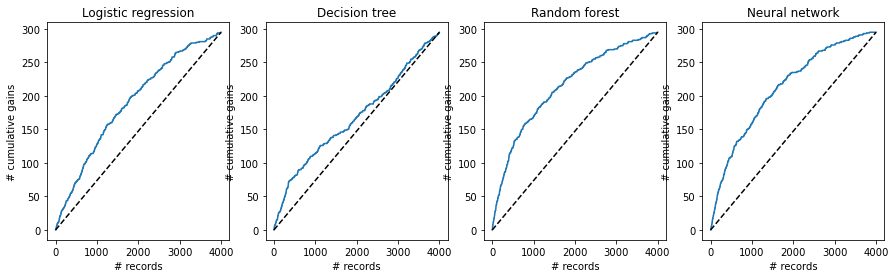

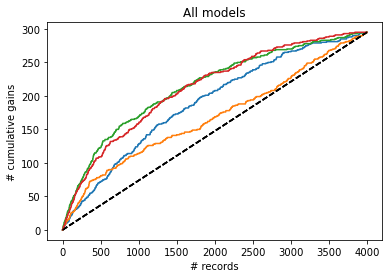

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 4))

def modelGainsChart(model, title, ax=None):
    result = pd.DataFrame({
        'actual': valid_y,
        'prob': model.predict_proba(valid_X)[:, 1]
    })

    result = result.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    ax = gainsChart(result.actual, ax=ax)
    ax.set_title(title)
    return ax

modelGainsChart(logit_reg, 'Logistic regression', axes[0])
modelGainsChart(dtree, 'Decision tree', axes[1])
modelGainsChart(rf, 'Random forest', axes[2])
modelGainsChart(neuralNet, 'Neural network', axes[3])

ax = modelGainsChart(logit_reg, 'Logistic regression')
modelGainsChart(dtree, 'Decision tree', ax)
modelGainsChart(rf, 'Random forest', ax)
modelGainsChart(neuralNet, 'Neural network', ax)
ax.set_title('All models')

Based on the gains charts, we would pick either random forest or neural network. Both show a higher gain for highly ranked records. 